In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv


In [2]:
!pip install twython

In [3]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
data=pd.read_csv('../input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv')
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
import re
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

In [6]:
data['text'] = data['text'].apply(lambda x:clean(x))

In [7]:
sia=SIA()
scores=[]
for i in range(len(data['text'])):
    
    score = sia.polarity_scores(data['text'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data['sentiment']=pd.Series(np.array(sentiment))

In [8]:
import string

def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text
data['text'] = data['text'].apply(lambda x:clean_text(x))

data['text']

0         same folks said daikon paste could treat a cyt...
1         while the world has been on the wrong side of ...
2         coronavirus sputnikv astrazeneca pfizerbiontec...
3         facts are immutable senator even when youre no...
4         explain to me again why we need a vaccine bori...
                                ...                        
125901    the who said its review of how russia produces...
125902    who raises concern on crosscontamination insuf...
125903                             sputnikv paid hyderabad 
125904    livenews moldova capital chisinau mayor ion ce...
125905    when was the sputnikv  exploratory stageanimal...
Name: text, Length: 125906, dtype: object

In [9]:
df=pd.DataFrame()
df['text']=data['text']
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['text'].apply(lambda x: tokenization(x.lower()))
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['No_stopwords'] = df['tokenized'].apply(lambda x: remove_stopwords(x))

ps = nltk.PorterStemmer()

def stemming1(text):
    text = [ps.stem(word) for word in text]
    return text

df['stemmed_porter'] = df['No_stopwords'].apply(lambda x: stemming1(x))

from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
def stemming2(text):
    text = [s_stemmer.stem(word) for word in text]
    return text
df['stemmed_snowball'] = df['No_stopwords'].apply(lambda x: stemming2(x))

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['lemmatized'] = df['No_stopwords'].apply(lambda x: lemmatizer(x))



In [10]:
df.head(10)

,text,tokenized,No_stopwords,stemmed_porter,stemmed_snowball,lemmatized
0,same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea...","[folks, said, daikon, paste, could, treat, cyt...","[folk, said, daikon, past, could, treat, cytok...","[folk, said, daikon, past, could, treat, cytok...","[folk, said, daikon, paste, could, treat, cyto..."
1,while the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,...","[world, wrong, side, history, year, hopefully,...","[world, wrong, side, histori, year, hope, bigg...","[world, wrong, side, histori, year, hope, bigg...","[world, wrong, side, history, year, hopefully,..."
2,coronavirus sputnikv astrazeneca pfizerbiontec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronaviru, sputnikv, astrazeneca, pfizerbion...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,facts are immutable senator even when youre no...,"[facts, are, immutable, senator, even, when, y...","[facts, immutable, senator, even, youre, ethic...","[fact, immut, senat, even, your, ethic, sturdi...","[fact, immut, senat, even, your, ethic, sturdi...","[fact, immutable, senator, even, youre, ethica..."
4,explain to me again why we need a vaccine bori...,"[explain, to, me, again, why, we, need, a, vac...","[explain, need, vaccine, borisjohnson, matthan...","[explain, need, vaccin, borisjohnson, matthanc...","[explain, need, vaccin, borisjohnson, matthanc...","[explain, need, vaccine, borisjohnson, matthan..."
5,does anyone have any useful adviceguidance for...,"[does, anyone, have, any, useful, adviceguidan...","[anyone, useful, adviceguidance, whether, covi...","[anyon, use, adviceguid, whether, covid, vacci...","[anyon, use, adviceguid, whether, covid, vacci...","[anyone, useful, adviceguidance, whether, covi..."
6,it is a bit sad to claim the fame for success ...,"[it, is, a, bit, sad, to, claim, the, fame, fo...","[bit, sad, claim, fame, success, vaccination, ...","[bit, sad, claim, fame, success, vaccin, patri...","[bit, sad, claim, fame, success, vaccin, patri...","[bit, sad, claim, fame, success, vaccination, ..."
7,there have not been many bright days in but h...,"[there, have, not, been, many, bright, days, i...","[many, bright, days, best, bidenharris, winnin...","[mani, bright, day, best, bidenharri, win, ]","[mani, bright, day, best, bidenharri, win, ]","[many, bright, day, best, bidenharris, winning, ]"
8,covid vaccine you getting it covidvaccine pfi...,"[covid, vaccine, you, getting, it, covidvaccin...","[covid, vaccine, getting, covidvaccine, pfizer...","[covid, vaccin, get, covidvaccin, pfizerbionte...","[covid, vaccin, get, covidvaccin, pfizerbionte...","[covid, vaccine, getting, covidvaccine, pfizer..."
9,covidvaccine states will start getting monday...,"[covidvaccine, states, will, start, getting, m...","[covidvaccine, states, start, getting, monday,...","[covidvaccin, state, start, get, monday, us, s...","[covidvaccin, state, start, get, monday, us, s...","[covidvaccine, state, start, getting, monday, ..."


In [11]:
temp = data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='coolwarm_r')

,sentiment,text
1,Neutral,62042
2,Positive,42186
0,Negative,21678


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
n = nltk.WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['text'])

In [13]:
print (text_counts)

  (0, 22614)	1
  (0, 53597)	1
  (0, 14824)	1
  (0, 45771)	1
  (0, 63234)	1
  (0, 14755)	1
  (0, 59015)	1
  (0, 46585)	1
  (1, 68856)	1
  (1, 69028)	1
  (1, 27328)	1
  (1, 69373)	1
  (1, 27626)	1
  (1, 6768)	1
  (1, 65416)	1
  (1, 19228)	1
  (1, 68102)	1
  (1, 20587)	1
  (2, 46585)	1
  (2, 13204)	1
  (2, 58173)	1
  (2, 4290)	1
  (2, 39589)	1
  (2, 53271)	1
  (2, 65511)	1
  :	:
  (125902, 58765)	1
  (125903, 58173)	1
  (125903, 45199)	1
  (125903, 28201)	1
  (125904, 58173)	1
  (125904, 51813)	1
  (125904, 12076)	1
  (125904, 65405)	1
  (125904, 9115)	1
  (125904, 9403)	1
  (125904, 37879)	1
  (125904, 35583)	1
  (125904, 39852)	1
  (125904, 11297)	1
  (125904, 10882)	1
  (125904, 30572)	1
  (125904, 9967)	1
  (125905, 58173)	1
  (125905, 61191)	1
  (125905, 48229)	1
  (125905, 28856)	1
  (125905, 21046)	1
  (125905, 58411)	1
  (125905, 40741)	1
  (125905, 58417)	1


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, data['sentiment'], test_size=0.25, random_state=5)

In [15]:
print (X_train)

  (0, 68709)	1
  (0, 60461)	1
  (0, 13427)	1
  (0, 45044)	1
  (0, 60002)	1
  (0, 47047)	1
  (1, 58173)	1
  (1, 2426)	1
  (1, 19202)	1
  (1, 6446)	1
  (1, 32011)	2
  (1, 33531)	1
  (1, 33341)	1
  (2, 46585)	1
  (2, 65511)	1
  (2, 45199)	1
  (2, 30817)	1
  (2, 32395)	1
  (2, 49864)	1
  (2, 36706)	1
  (2, 6294)	1
  (3, 1244)	1
  (3, 25119)	1
  (3, 13518)	1
  (3, 56961)	1
  :	:
  (94425, 62784)	1
  (94425, 13518)	1
  (94425, 24488)	1
  (94426, 10464)	1
  (94426, 65747)	1
  (94426, 65052)	1
  (94426, 29385)	1
  (94426, 58622)	1
  (94426, 13518)	1
  (94426, 13934)	1
  (94427, 2426)	1
  (94427, 24791)	1
  (94427, 62042)	1
  (94427, 60770)	1
  (94427, 22621)	1
  (94427, 34768)	1
  (94427, 20757)	1
  (94427, 33523)	1
  (94428, 39589)	1
  (94428, 3687)	1
  (94428, 54210)	1
  (94428, 66276)	1
  (94428, 27007)	1
  (94428, 35610)	1
  (94428, 50613)	1


In [16]:
from sklearn.naive_bayes import MultinomialNB

In [17]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [18]:
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)

In [19]:
print(str('{:04.2f}'.format(accuracy_score*100))+'%')

77.63%


In [20]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
CNB = ComplementNB()
GNB = GaussianNB()
BNB = BernoulliNB()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(df['text'])

#splitting the data in test and training
#from sklearn.model_selection() import train_test_split()
x_train, x_test, y_train, y_test = train_test_split(text_count_2, data['sentiment'],test_size=0.25,random_state=5)

#defining the model
#compilimg the model -> we are going to use already used models  MNB, CNB, BNB
#fitting the model
MNB.fit(x_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(x_test), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

CNB.fit(x_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(x_test), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')



accuracy_score_mnb = 76.76%
accuracy_score_bnb = 77.03%
accuracy_score_cnb = 77.94%


In [22]:
print(text_count_2)

  (0, 46805)	0.15144981249931627
  (0, 59262)	0.3658996444942309
  (0, 14832)	0.4273303125251527
  (0, 63526)	0.33227411032259857
  (0, 13458)	0.21757022949041352
  (0, 45988)	0.3796499389693358
  (0, 14902)	0.44220984843425126
  (0, 53816)	0.1946768684799434
  (0, 22731)	0.27548251109608324
  (0, 53999)	0.22215534215107735
  (1, 20685)	0.34949007866604315
  (1, 68421)	0.3140428016084507
  (1, 19320)	0.3061922295602771
  (1, 65720)	0.1539410052949178
  (1, 6825)	0.29610854741177717
  (1, 27772)	0.2835969124933642
  (1, 69713)	0.2243871892290795
  (1, 62249)	0.14167345753025837
  (1, 27474)	0.2938919986080285
  (1, 44041)	0.08502888994819621
  (1, 56454)	0.19265785133371882
  (1, 69370)	0.29362388031089226
  (1, 44373)	0.10837964941305589
  (1, 6075)	0.17713433947803595
  (1, 26508)	0.1441469432622074
  :	:
  (125904, 10952)	0.3415743417028491
  (125904, 11366)	0.3300810027349588
  (125904, 40030)	0.29595311534952184
  (125904, 35749)	0.3300810027349588
  (125904, 38052)	0.2370091371267

In [23]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

In [24]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(df['text'],(1,1),20)
bigram_df=ngram_df(df['text'],(2,2),20)
trigram_df=ngram_df(df['text'],(3,3),20)
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ",
                  showlegend=False,title_x=0.5,height=1200,template="plotly_dark")
fig.show()

In [25]:
Positive_tweet = data[data['sentiment']=='Positive'].reset_index()
Negative_tweet = data[data['sentiment']=='Negative'].reset_index()
Neutral_tweet = data[data['sentiment']=='Neutral'].reset_index()

In [26]:
Positive_tweet.head()

,index,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,Positive
1,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,Positive
2,5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,does anyone have any useful adviceguidance for...,NaN,Twitter for iPhone,0,0,False,Positive
3,6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,Positive
4,7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,there have not been many bright days in but h...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,Positive


In [27]:
import unicodedata

In [28]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english') 
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [29]:
words = basic_clean(''.join(str(Positive_tweet['text'].tolist())))

In [30]:
print (Positive_tweet['text'].count())

42186


Text(0.5, 0, '# of Occurances')

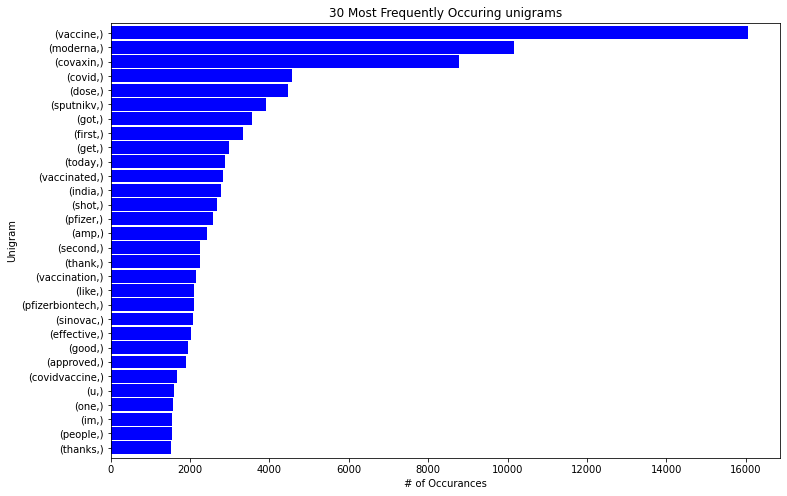

In [31]:
unigrams_series =(pd.Series(nltk.ngrams(words, 1)).value_counts())[:30]
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')



In [32]:
print (unigrams_series)


(vaccine,)           16062
(moderna,)           10149
(covaxin,)            8776
(covid,)              4568
(dose,)               4458
(sputnikv,)           3927
(got,)                3554
(first,)              3341
(get,)                2971
(today,)              2885
(vaccinated,)         2831
(india,)              2774
(shot,)               2692
(pfizer,)             2572
(amp,)                2423
(second,)             2249
(thank,)              2245
(vaccination,)        2154
(like,)               2112
(pfizerbiontech,)     2101
(sinovac,)            2084
(effective,)          2029
(good,)               1941
(approved,)           1893
(covidvaccine,)       1675
(u,)                  1594
(one,)                1579
(im,)                 1547
(people,)             1535
(thanks,)             1526
dtype: int64


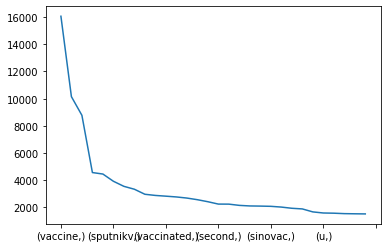

In [33]:
unigrams_series.plot()
plt.show()

Text(0.5, 0, '# of Occurances')

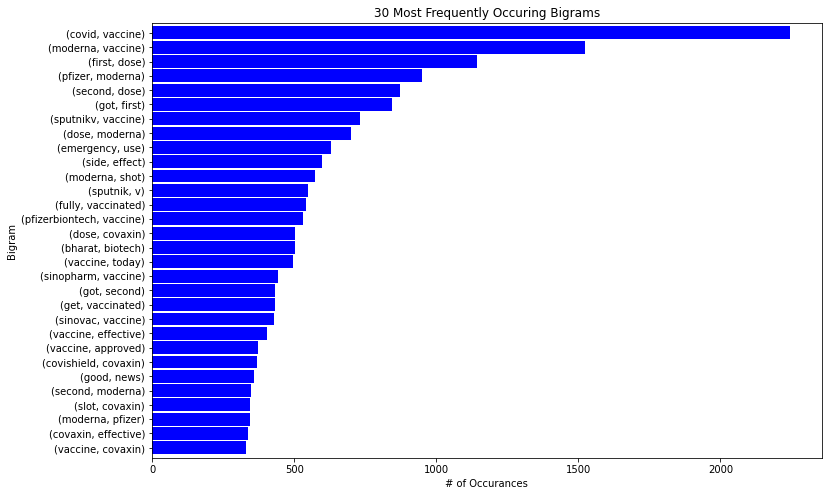

In [34]:
bigrams_series =(pd.Series(nltk.ngrams(words, 2)).value_counts())[:30]
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')


Text(0.5, 0, '# of Occurances')

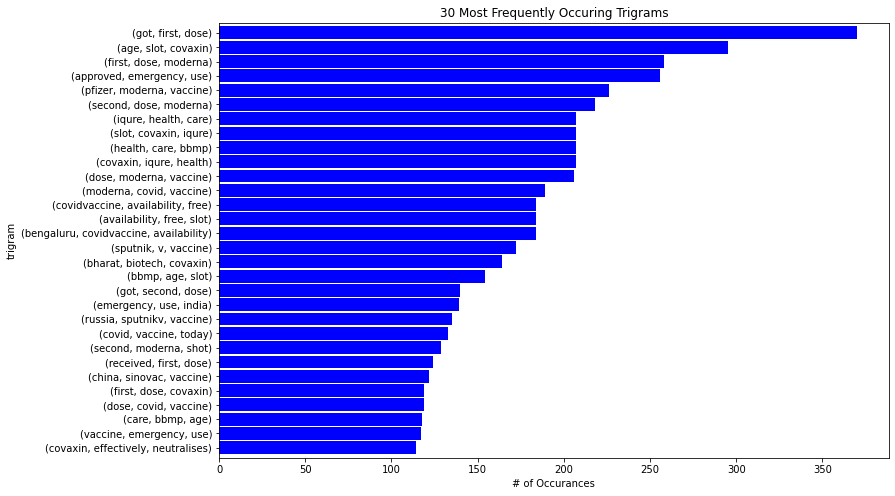

In [35]:
trigrams_series =(pd.Series(nltk.ngrams(words, 3)).value_counts())[:30]
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Trigrams')
plt.ylabel('trigram')
plt.xlabel('# of Occurances')

In [36]:
nwords = basic_clean(''.join(str(Negative_tweet['text'].tolist())))

Text(0.5, 0, '# of Occurances')

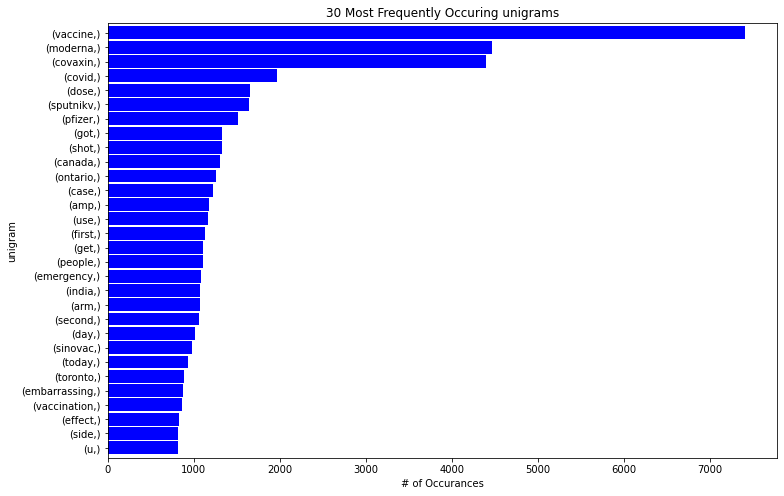

In [37]:
unigrams_nseries =(pd.Series(nltk.ngrams(nwords, 1)).value_counts())[:30]
unigrams_nseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring unigrams')
plt.ylabel('unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

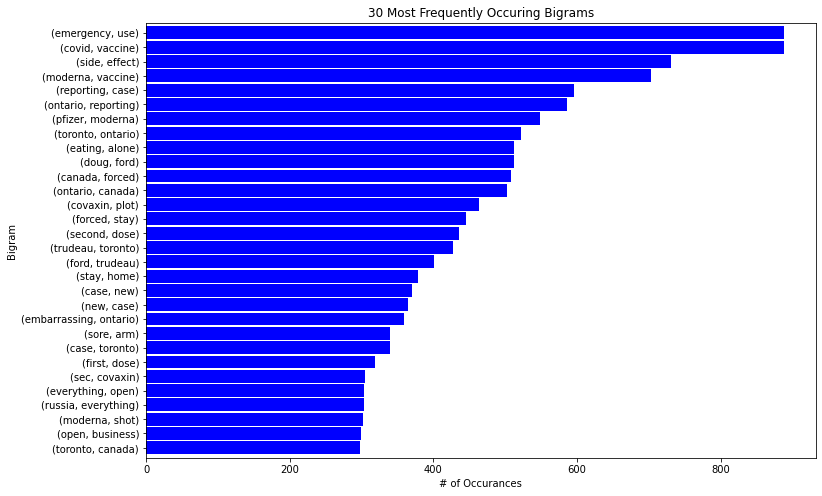

In [38]:
bigrams_nseries =(pd.Series(nltk.ngrams(nwords, 2)).value_counts())[:30]
bigrams_nseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')


Text(0.5, 0, '# of Occurances')

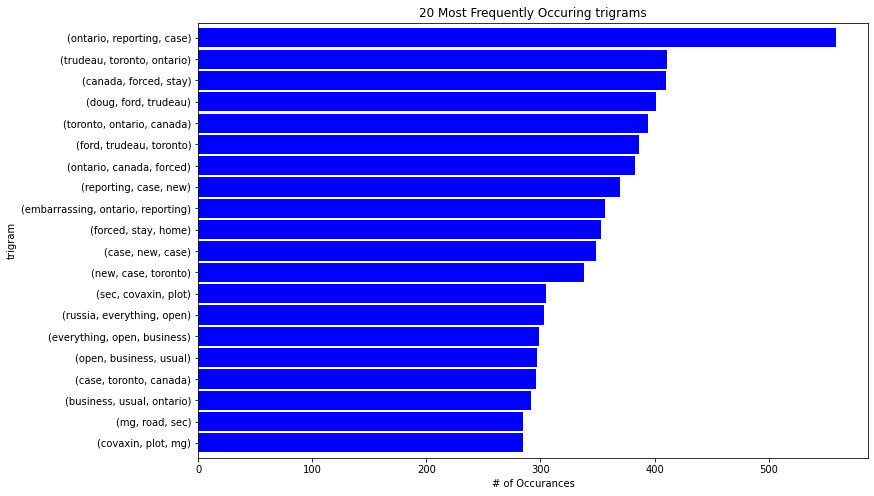

In [39]:
trigrams_nseries =(pd.Series(nltk.ngrams(nwords, 3)).value_counts())[:20]
trigrams_nseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring trigrams')
plt.ylabel('trigram')
plt.xlabel('# of Occurances')

In [40]:
neuwords = basic_clean(''.join(str(Neutral_tweet['text'].tolist())))

Text(0.5, 0, '# of Occurances')

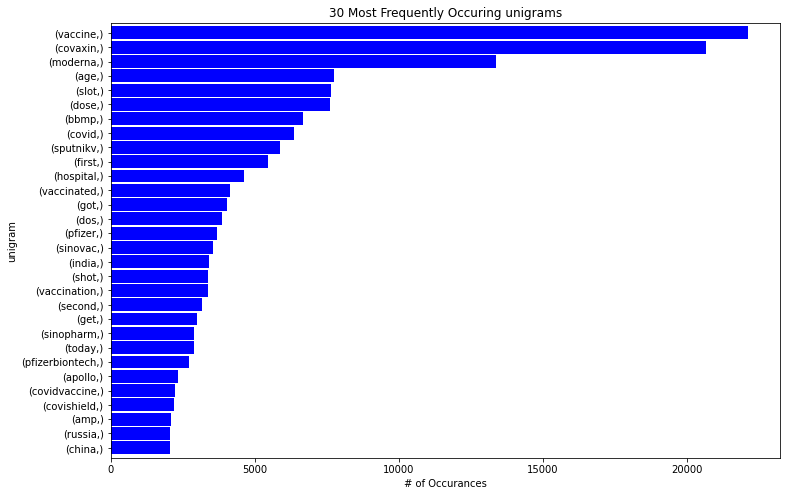

In [41]:
unigrams_neuseries =(pd.Series(nltk.ngrams(neuwords, 1)).value_counts())[:30]
unigrams_neuseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring unigrams')
plt.ylabel('unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

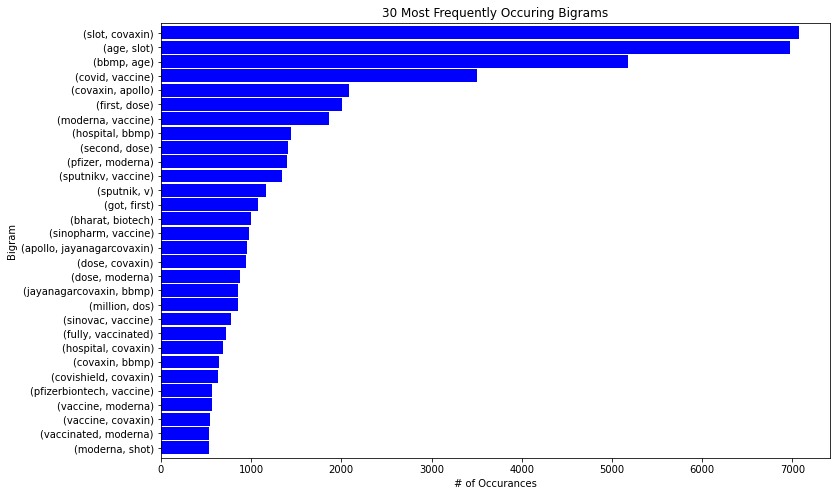

In [42]:
bigrams_neuseries =(pd.Series(nltk.ngrams(neuwords, 2)).value_counts())[:30]
bigrams_neuseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

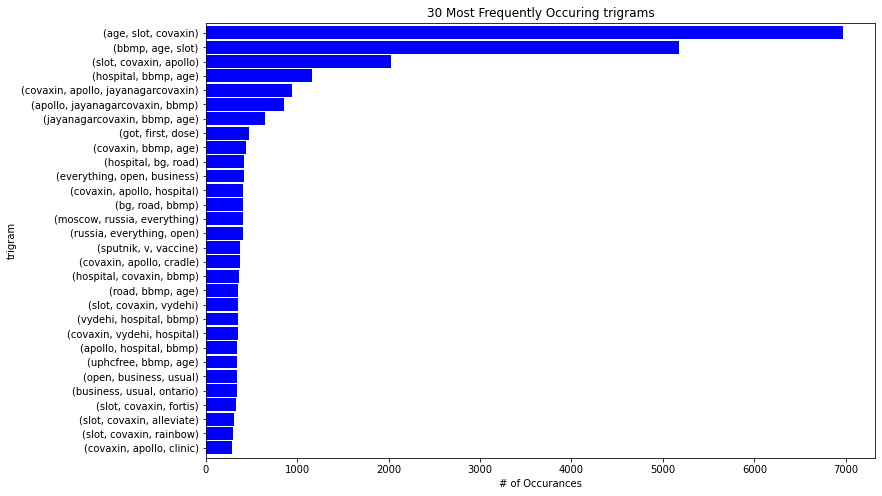

In [43]:
trigrams_neuseries =(pd.Series(nltk.ngrams(neuwords, 3)).value_counts())[:30]
trigrams_neuseries.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring trigrams')
plt.ylabel('trigram')
plt.xlabel('# of Occurances')

In [44]:
import scattertext as st

In [45]:
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,Positive
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,Negative
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,Positive
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts are immutable senator even when youre no...,NaN,Twitter Web App,446,2129,False,Neutral
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine bori...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,Neutral


In [46]:
data1=pd.DataFrame()
from IPython.display import IFrame


In [47]:
data1=data.copy()

data1['binary_sentiment'] = data1['sentiment'].apply(lambda x: x if x =="Negative" else "non-negative")
data1['date'] = data1['date'].apply(str)

data = data1.assign(
    parse=lambda data: data.text.apply(st.whitespace_nlp_with_sentences)
)

corpus = st.CorpusFromParsedDocuments(
    data, category_col='binary_sentiment', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

html = st.produce_scattertext_explorer(
    corpus,
    category='Negative', category_name='Negative', not_category_name='Neutral/Positive',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000, metadata=corpus.get_df()['date'],
    transform=st.Scalers.dense_rank
    
)



In [48]:
open('./demo_compact.html', 'w').write(html)
IFrame(src='./demo_compact.html', width=1200, height=700)

In [49]:
docs=Positive_tweet['text'].tolist()
cv=CountVectorizer(max_df=0.85,stop_words='english',max_features=20000)
word_count_vector=cv.fit_transform(docs)

In [50]:
word_count_vector

<42186x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 366145 stored elements in Compressed Sparse Row format>

In [51]:
list(cv.vocabulary_.keys())[:10]

['folks',
 'said',
 'paste',
 'treat',
 'cytokine',
 'storm',
 'pfizerbiontech',
 'coronavirus',
 'sputnikv',
 'astrazeneca']

In [52]:

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

# ****Features of positive tweets using tf-idf:

In [53]:


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=32):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


feature_names=cv.get_feature_names()


#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform(docs))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 32
keywords=extract_topn_from_vector(feature_names,sorted_items,32)


print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])



===Keywords===
welcome 1.0
sputnikv 1.0
oxfordastrazeneca 1.0
moderna 1.0
covaxin 1.0
woot 0.965
cool 0.986
bomb 0.974
shefvaidya 0.968
fdacber 0.968
youre 0.968
shots 0.942
invincible 0.965
harmless 0.965
assist 0.965
rescue 0.963
smiling 0.957
celebrating 0.955
woohoo 0.951
trustable 0.95
remarkable 0.95
yay 0.947
okay 0.945
progress 0.945
xxx 0.945
hurrah 0.944
peppe 0.944
yeah 0.944
joke 0.941
lol 0.94


In [54]:
ndocs=Negative_tweet['text'].tolist()
neudocs=Neutral_tweet['text'].tolist()

In [55]:
word_count_vector_neu=cv.fit_transform(neudocs)

In [56]:

word_count_vector_neu

<62042x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 472850 stored elements in Compressed Sparse Row format>

In [57]:
list(cv.vocabulary_.keys())[:10]

['facts',
 'senator',
 'youre',
 'ethically',
 'acknowledge',
 'born',
 'explain',
 'need',
 'vaccine',
 'borisjohnson']

In [58]:
tfidf_transformer.fit(word_count_vector_neu)

TfidfTransformer()

# ****Features of neutral tweets using tf-idf:

In [59]:
feature_names=cv.get_feature_names()




#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform(neudocs))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 32
keywords=extract_topn_from_vector(feature_names,sorted_items,32)


print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=32):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


===Keywords===
woke 1.0
vizhpuneet 1.0
viphelicopter 1.0
victorblackwell 1.0
vacinnatedpfizerbiontech 1.0
vaccine 1.0
usargb 1.0
twitter 1.0
time 1.0
thing 1.0
sputnikv 1.0


In [60]:
word_count_vector_n=cv.fit_transform(ndocs)
list(cv.vocabulary_.keys())[:10]

['world',
 'wrong',
 'history',
 'year',
 'hopefully',
 'biggest',
 'vaccination',
 'effort',
 'weve',
 'ev']

In [61]:
tfidf_transformer.fit(word_count_vector_n)

TfidfTransformer()

# ****Features of negative tweets using tf-idf:

In [62]:
feature_names=cv.get_feature_names()




#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform(ndocs))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 32
keywords=extract_topn_from_vector(feature_names,sorted_items,100)


print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=32):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


===Keywords===
sputnikv 1.0
askanshul 0.968
underestimated 0.967
dancing 0.966
unwanted 0.965
gifted 0.964
victim 0.951
comments 0.951
prick 0.827
joy 0.944
bones 0.936
hate 0.936
shame 0.881
fuck 0.826
efficient 0.926
tragic 0.924
shit 0.924
killer 0.916
pratidintime 0.916
jacindaardern 0.916
contentcmd 0.912
boycott 0.908
bluetooth 0.9
year 0.899
sideeffects 0.897
trust 0.888
narratives 0.885
envy 0.883
thehindu 0.882
bicep 0.88
help 0.878
waste 0.873
sticker 0.873
failed 0.873
stabbed 0.872
fucked 0.872
human 0.868
rs 0.867
equals 0.865
effects 0.861
replies 0.86
doubted 0.86
shoot 0.857
covidiots 0.856
stands 0.855
stuck 0.854
gona 0.853
fools 0.851
gotten 0.851
lancet 0.85
pressure 0.85
good 0.85
poison 0.849
hurting 0.846
regulators 0.846
suck 0.844
forbidden 0.844
laalejandro 0.843
panic 0.843
strike 0.841
whosearo 0.839
gst 0.839
safe 0.838
vanessabritomia 0.836
pricked 0.834
ohio 0.834
realise 0.833
kills 0.832
tribes 0.831
iankursingh 0.829
cpso 0.829
micrograms 0.828
tika 0